In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import os



In [31]:

def fft_eeg(signal, fs=256):
    signal_np = signal.cpu().numpy()
    freq_signal = np.fft.rfft(signal_np, axis=-1)
    freqs = np.fft.rfftfreq(signal.shape[-1], d=1/fs)
    return freq_signal, freqs

def inject_7hz_noise(freq_signal, freqs, power=0.1):
    target_band = (freqs >= 6.5) & (freqs <= 7.5)
    noise = np.random.randn(*freq_signal.shape) + 1j * np.random.randn(*freq_signal.shape)
    freq_signal[:, :, target_band] += power * noise[:, :, target_band]
    return freq_signal

def ifft_eeg(freq_signal, original_shape):
    time_signal = np.fft.irfft(freq_signal, n=original_shape[-1], axis=-1)
    return torch.tensor(time_signal, dtype=torch.float32)


def plot_power(freq_signal, freqs, idx=0):
    power = np.abs(freq_signal[idx, 0])**2
    plt.plot(freqs, power)
    plt.title("Power Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.xlim(0, 30)
    plt.show()


def plot_frequency_histogram(freq_signal, freqs, title="EEG Frequency Distribution", idx=0):
    """
    Plot power spectrum as a histogram for a given sample.
    freq_signal: output of FFT, shape (batch, channel, freq_bins)
    freqs: frequency values in Hz
    """
    power = np.abs(freq_signal[idx, 0])**2  # Power = magnitude^2
    plt.figure(figsize=(15, 4))
    plt.bar(freqs, power, width=1.0, color='blue')
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.xlim(0, 60)  # Limit to 60 Hz for typical EEG
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [15]:
# Load CSV (assuming 1D EEG signal per row or column)
df = pd.read_csv('C:/Github/EEG-Mouse/data/train.csv', header=None)

# Convert to tensor
eeg_np = df.to_numpy().astype('float32')

# If shape is (samples,), convert to (1, 1, samples)
# If shape is (n_samples, timepoints), convert to (n_samples, 1, timepoints)
if eeg_np.ndim == 1:
    eeg_np = eeg_np[None, None, :]  # (1, 1, time)
elif eeg_np.ndim == 2:
    eeg_np = eeg_np[:, None, :]     # (batch, 1, time)

eeg_tensor = torch.tensor(eeg_np)

In [20]:
# Simulate input EEG (e.g., z-scored)
# eeg = torch.randn(16, 1, 1280)  # batch=16, 1 channel, 1280 timepoints

# FFT
freq_signal, freqs = fft_eeg(eeg_tensor, fs=256)

# Inject 7 Hz noise
freq_signal_noisy = inject_7hz_noise(freq_signal, freqs, power=0.2)

# IFFT
eeg_noisy_tensor = ifft_eeg(freq_signal_noisy, eeg_tensor.shape)




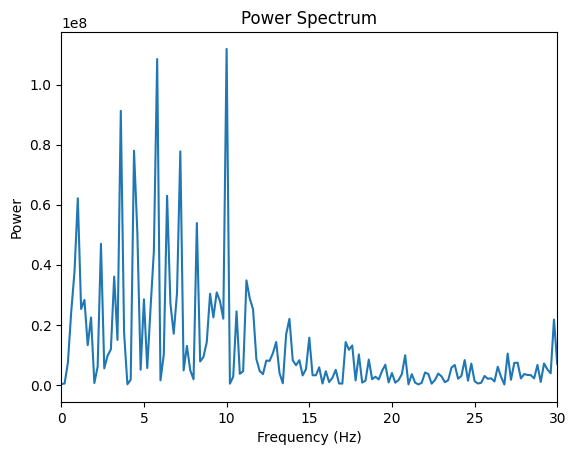

In [19]:
plot_power(freq_signal, freqs)


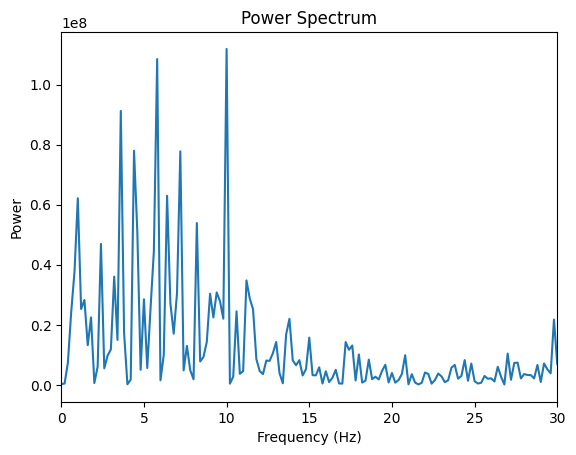

In [21]:
plot_power(freq_signal_noisy, freqs)

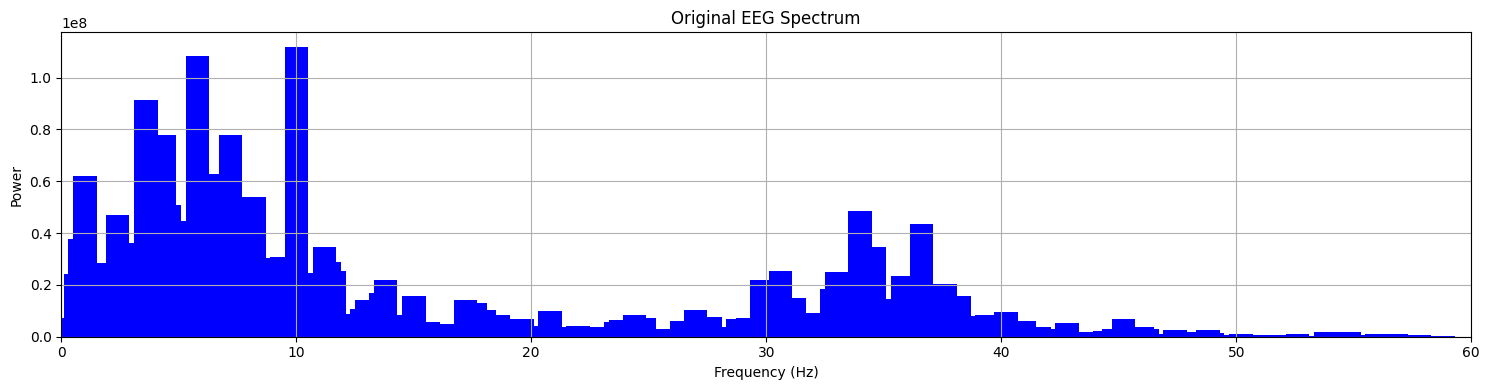

In [32]:
plot_frequency_histogram(freq_signal, freqs, title="Original EEG Spectrum")


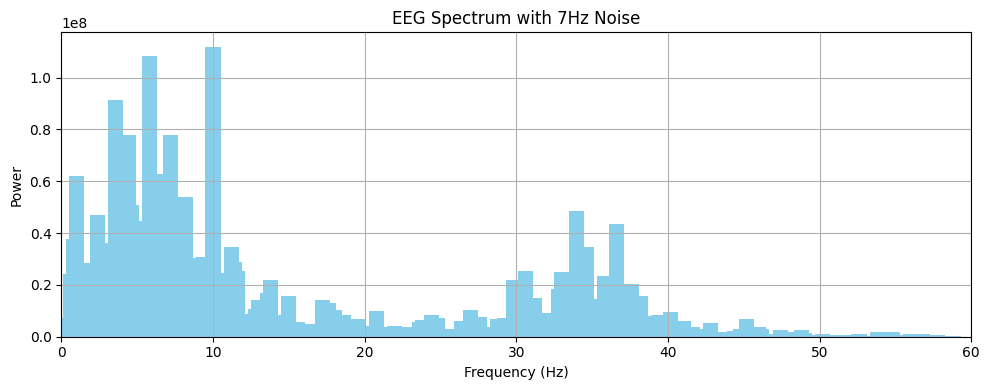

In [28]:
plot_frequency_histogram(freq_signal_noisy, freqs, title="EEG Spectrum with 7Hz Noise")
